Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import figure_standard
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import h5py
import math
import os

In [2]:
n_boot = 10001
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()

In [3]:
### a
# load data
df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")

In [4]:
# rename columns
df = df.rename(columns={"o_kappa": "All","w_kappa": "Wake","n1_kappa": "N1","n2_kappa": "N2","n3_kappa": "N3","rem_kappa": "REM"})

In [5]:
# melt this, using only set=3 (test set)
data = pd.melt(df.loc[df['set']==3, ['decade','All', 'Wake', 'N1', 'N2', 'N3', 'REM']], id_vars=['decade'], value_vars=['All', 'Wake', 'N1', 'N2', 'N3', 'REM'])

In [6]:
# remove the NaNs
data = data[~np.isnan(data['value'])]

In [7]:
# # create a copy of all of the data, but set the decade to all
data2 = data.copy(deep=True)
data2['decade'] = 'All'

In [8]:
# combine those
data = pd.concat([data, data2], ignore_index=True)

In [9]:
df.loc[df['study']=='ccshs', 'study'] = 'CCSHS'
df.loc[df['study']=='cfs', 'study'] = 'CFS'
df.loc[df['study']=='chat', 'study'] = 'CHAT'
df.loc[df['study']=='mesa', 'study'] = 'MESA'
df.loc[df['study']=='wsc', 'study'] = 'WSC'

In [10]:

# melt this, using only set=3 (test set)
data = pd.melt(df.loc[df['set']==3, ['decade','All', 'Wake', 'N1', 'N2', 'N3', 'REM', 'study']], id_vars=['decade', 'study'], value_vars=['All', 'Wake', 'N1', 'N2', 'N3', 'REM'])

In [11]:
### b

df_model = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")
df_test = df_model[df_model['set'] ==3]

bins = [x/1000 for x in range(0, 1000, 25)]
bins += [1.001]

for stage in ['w', 'n1', 'n2', 'n3', 'rem']:
    df_test[stage + '_percent_bin'] = 0
    for i, _ in enumerate(bins[0:-1]):
        avg = (bins[i] + bins[i+1])/2
        sb_indexes = df_test[(df_test[stage + '_percent'] >= bins[i]) & (df_test[stage + '_percent'] < bins[i+1])].index
        df_test.loc[sb_indexes, stage + '_percent_bin'] = 100*avg

/tmp/ipykernel_1274340/146445567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[stage + '_percent_bin'] = 0
/tmp/ipykernel_1274340/146445567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[stage + '_percent_bin'] = 0
/tmp/ipykernel_1274340/146445567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [12]:
### c

with h5py.File("../2_intermediate_data/captum_attrs.mat") as file_h:
    attrs = file_h['attrs'][:]

attrs = np.transpose(attrs)

offset = 540
max_i = offset * 2 + 1

attrs_df = pd.DataFrame(data=np.median(attrs, axis=0), columns=['median'])
attrs_df['x'] = [x-offset for x in range(max_i)]
attrs_df['prc_2.5'] = np.percentile(attrs, 2.5, axis=0)
attrs_df['prc_97.5'] = np.percentile(attrs, 97.5, axis=0)
attrs_df['dummy']=0

In [13]:
### d
# load data
df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")
# per original column which was a boolean for "MALE"
df.loc[df['male']==0, 'male'] = 'female'
df.loc[df['male']==1, 'male'] = 'male'
# rename columns
df = df.rename(columns={"o_kappa": "Overall","w_kappa": "Wake","n1_kappa": "N1","n2_kappa": "N2","n3_kappa": "N3","rem_kappa": "REM"})

# melt this, using only set=3 (test set)
data_sex1 = pd.melt(df.loc[df['set']==3, ['male','Overall', 'Wake', 'N1', 'N2', 'N3', 'REM']], id_vars=['male'], value_vars=['Overall', 'Wake', 'N1', 'N2', 'N3', 'REM'])

data_sex_copy = data_sex1.copy(deep=True)
data_sex_copy['male'] = 'all'

data_sex = pd.concat([data_sex1, data_sex_copy])

In [14]:
### e
# melt this, using only set=3 (test set)
data_wake = pd.melt(df.loc[df['set']==3, ['wake_epochs_before_sleep','Overall', 'Wake', 'N1', 'N2', 'N3', 'REM']], id_vars=['wake_epochs_before_sleep'], value_vars=['Overall'])

data_early = data_wake[data_wake['wake_epochs_before_sleep'] < 60]
data_early['early'] = 0

data_late = data_wake[(data_wake['wake_epochs_before_sleep'] >= 60) & (data_wake['wake_epochs_before_sleep'] < 180)]
data_late['early'] = 1

data_wake['early'] = 2

data_wake_all = pd.concat([data_early, data_late, data_wake])

data_wake_all['variable'] = 'Overall'

/tmp/ipykernel_1274340/2909934366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_early['early'] = 0
/tmp/ipykernel_1274340/2909934366.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_late['early'] = 1


In [15]:
### f
df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")

df_wake = df[df['set'] ==3]
df_wake['wake_min_before'] = df_wake['wake_epochs_before_sleep']*30/60
df_wake['dummy'] = 0

bin_size = 15
max_bin = math.ceil(df_wake['wake_min_before'].max()/bin_size)*bin_size + bin_size
bins = [x for x in range(0, max_bin, bin_size)]

while bins[-1] > 360:
    bins.pop()

bins.insert(0,-1)
bins

/tmp/ipykernel_1274340/2566652795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wake['wake_min_before'] = df_wake['wake_epochs_before_sleep']*30/60
/tmp/ipykernel_1274340/2566652795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wake['dummy'] = 0


[-1,
 0,
 15,
 30,
 45,
 60,
 75,
 90,
 105,
 120,
 135,
 150,
 165,
 180,
 195,
 210,
 225,
 240,
 255,
 270,
 285,
 300,
 315,
 330,
 345,
 360]

/tmp/ipykernel_1274340/3537093279.py:351: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


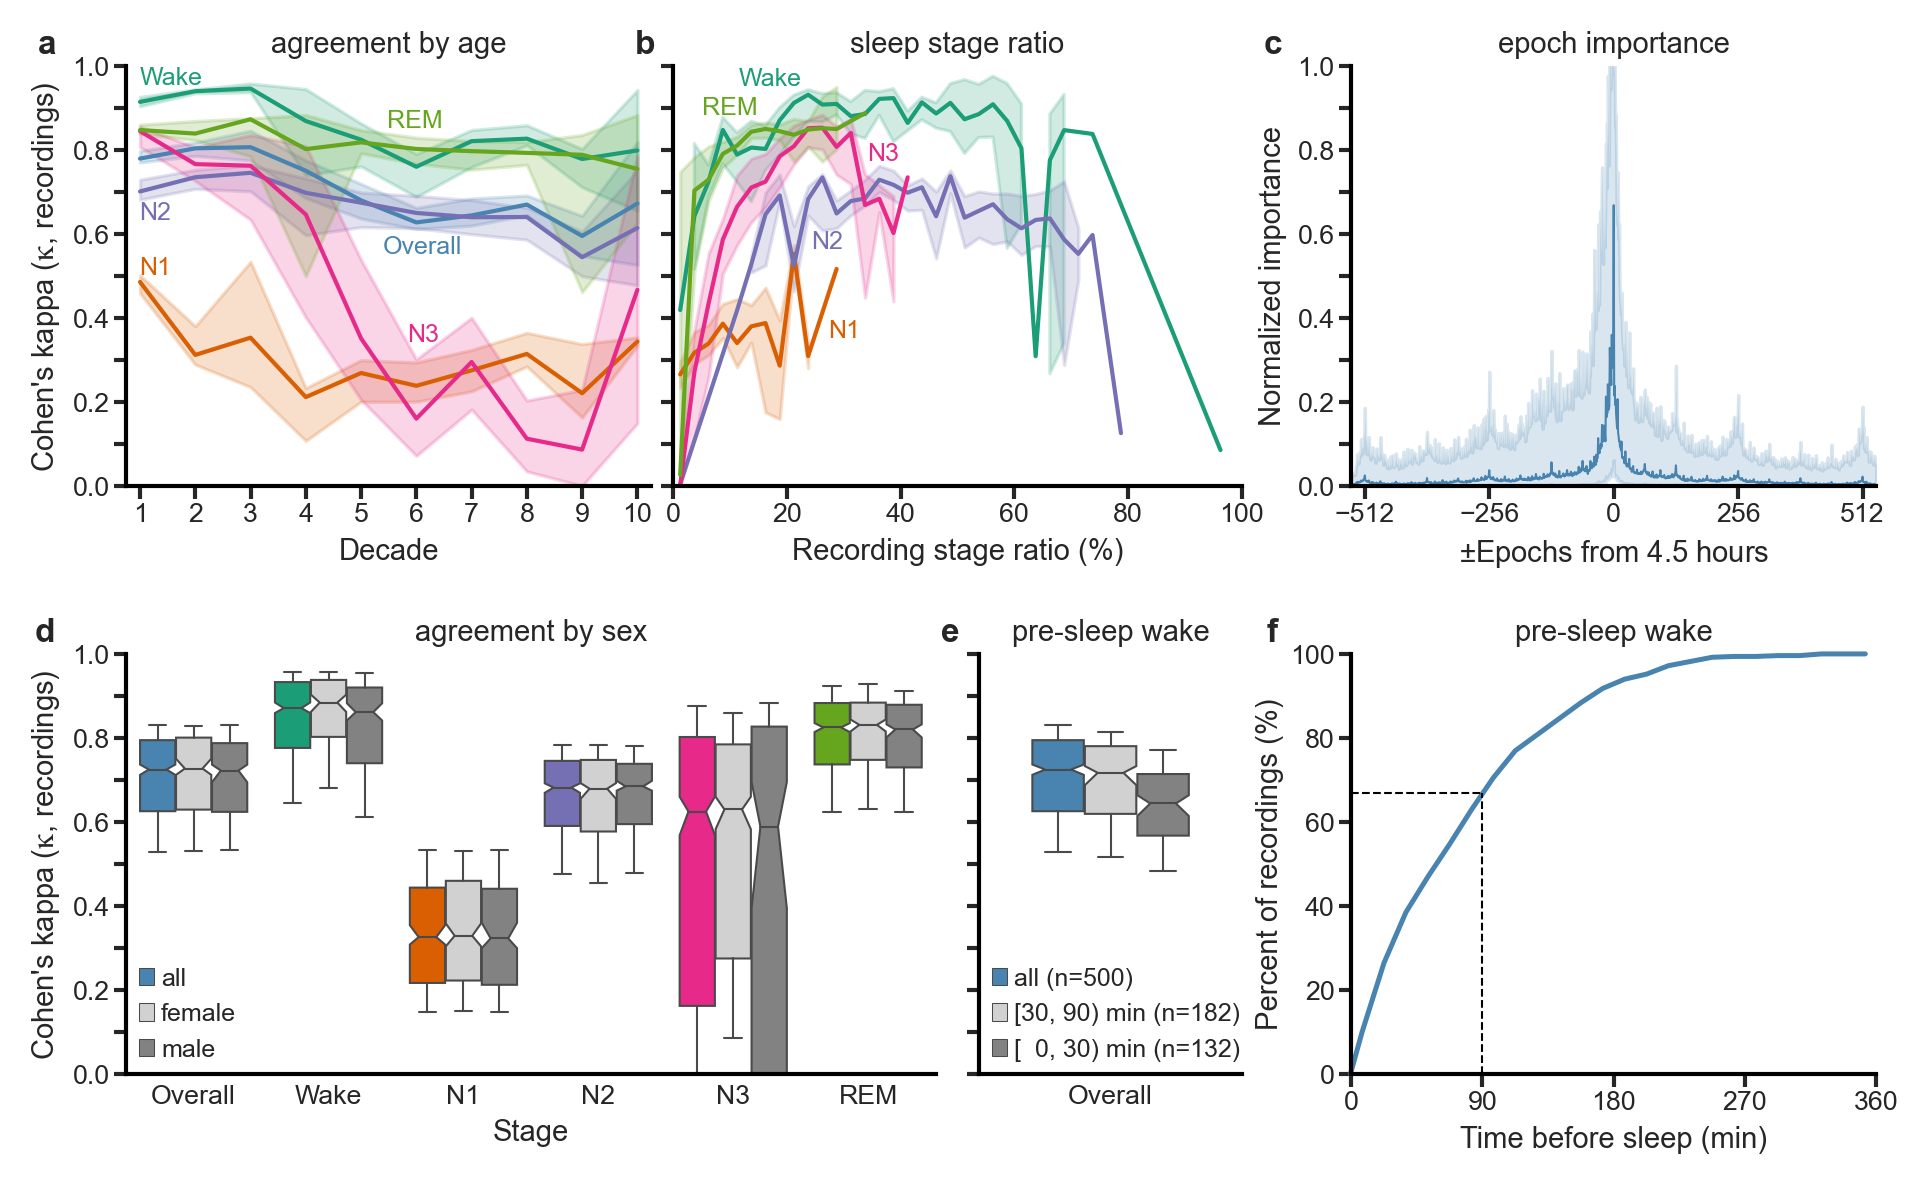

In [16]:


gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.5, 0.0, 0.5, 0.125, 1])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1:4], sharey=ax1)
# unused space for axis label
ax3 = plt.subplot(gs[0, 5:6], sharey=ax1)

ax4 = plt.subplot(gs[1, 0:2])
ax5 = plt.subplot(gs[1, 3], sharey=ax4)
ax6 = plt.subplot(gs[1, 5:6])

### a ###

sns.lineplot(y='value', x='decade', hue='variable', data=data, 
                  palette=main_palette,
                  estimator='median',
                  n_boot=n_boot,
                 linewidth=1,
                 ax=ax1)


ax1.set_xlim([0.75, 10.25])
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


ax1.set_ylim([0, 1])
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in ax1.get_yticklabels()[1::2]:
    label.set_visible(False)

labelpad = 2.5
ax1.set_ylabel('Cohen\'s kappa ($\kappa$, recordings)', fontweight=None, labelpad=labelpad)
ax1.set_xlabel('Decade', fontweight=None, labelpad=labelpad)


sns.despine(ax=ax1, right=True, top=True, bottom=False)
ax1.grid(False)
ax1.tick_params(axis='y', left=True, width=1, length=3, pad=1)
ax1.tick_params(axis='x', bottom=True, width=1, length=3, pad=1)

ax1.legend().remove()


ax1.text(0.565, 0.57, "Overall", transform=ax1.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[0])

ax1.text(0.025, 0.999, "Wake", transform=ax1.transAxes,
      fontsize=6, va='top', ha='left', color=main_palette[1])

ax1.text(0.025, 0.52, "N1", transform=ax1.transAxes,
      fontsize=6, va='center', ha='left', color=main_palette[2])

ax1.text(0.025, 0.65, "N2", transform=ax1.transAxes,
      fontsize=6, va='center', ha='left', color=main_palette[3])

ax1.text(0.565, 0.36, "N3", transform=ax1.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[4])

ax1.text(0.55, 0.87, "REM", transform=ax1.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[5])



### b ###

for i, stage in enumerate(['w', 'n1', 'n2', 'n3', 'rem']):
    sns.lineplot(data=df_test, x=stage+"_percent_bin", 
                y=stage+"_kappa", 
                linewidth=1,
                palette=[main_palette[i+1]],
                hue="set",
                n_boot=n_boot,
                estimator='median',
                ax=ax2
    )


ax2.set_xlim([0, 100])

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))


for label in ax2.get_yticklabels():
    label.set_visible(False)

ax2.legend().remove()

ax2.text(0.17, 0.97, "Wake", transform=ax2.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[1])

ax2.text(0.30, 0.37, "N1", transform=ax2.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[2])

ax2.text(0.27, 0.58, "N2", transform=ax2.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[3])

ax2.text(0.37, 0.79, "N3", transform=ax2.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[4])

ax2.text(0.10, 0.90, "REM", transform=ax2.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[5])


sns.despine(ax=ax2, right=True, top=True, bottom=False)
ax2.grid(False)
ax2.tick_params(axis='y', left=True, width=1, length=3, pad=1)
ax2.tick_params(axis='x', bottom=True, width=1, length=3, pad=1)



labelpad = 2.5
ax2.set_xlabel('Recording stage ratio (%)', fontweight=None, labelpad=labelpad)
ax2.set_ylabel('', fontweight=None, labelpad=labelpad)



### c ###



# function to return the lower and upper CIs
def errorbar_func(x):
    global attrs_df
    df_index = x.index[0]
    lower = attrs_df.loc[df_index, 'prc_2.5']
    upper = attrs_df.loc[df_index, 'prc_97.5']
    return lower, upper

# need to have two copies of the data to get the error bars to work
attrs_df2 = pd.concat([attrs_df, attrs_df])

sns.lineplot(data=attrs_df2, x="x", 
             y="median", 
             linewidth=0.5,
            palette=[main_palette[0]],
            hue="dummy",
            estimator="median",
            errorbar=errorbar_func,
            err_style='band',
            ax = ax3

)

ax3.set_ylim([0, 1])
ax3.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in ax3.get_yticklabels()[1::2]:
    label.set_visible(False)

ax3.set_xlim([-540, 540])
ax3.set_xticks([-512,-256, 0, 256, 512])


sns.despine(ax=ax3, right=True, top=True, bottom=False)
ax3.grid(False)
ax3.tick_params(axis='y', left=True, width=1, length=3, pad=1)
ax3.tick_params(axis='x', bottom=True, width=1, length=3, pad=1)

ax3.legend().remove()

labelpad = 2.5
ax3.set_ylabel('Normalized importance', fontweight=None, labelpad=labelpad)
ax3.set_xlabel('$\pm$Epochs from 4.5 hours', fontweight=None, labelpad=labelpad)




### d ###


palette = []
palette += [main_palette[0]]
palette += [sns.color_palette("Greys", 6)[1]]
palette += [sns.color_palette("Greys", 6)[3]]

hue_order = ['all', 'female', 'male']
sns.boxplot(y='value', x='variable', hue='male', data=data_sex, whis=[10, 90], 
      hue_order=hue_order,
      width=0.8,
      palette=palette,
      notch=True, bootstrap=n_boot,
      ax = ax4,
      saturation=1,
      showfliers=False, linewidth=0.5)


ax4.set_ylabel('Cohen\'s kappa ($\kappa$, recordings)', fontweight=None, labelpad=labelpad)
ax4.set_xlabel('Stage', fontweight=None, labelpad=labelpad)
ax4.set_ylim([0, 1])
ax4.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in ax4.get_yticklabels()[1::2]:
    label.set_visible(False)

sns.despine(ax=ax4, right=True, top=True, bottom=False)
ax4.grid(False)
ax4.tick_params(axis='y', left=True, width=1, length=3, pad=1)

for tick in ax4.get_xticklabels():
    tick.set_verticalalignment("bottom")

i = 0
for child in ax4.get_children():
    try:
        if child._label == '':
            facecolor = child._facecolor
            if abs(facecolor[0] - main_palette[0][0]) < 0.01:
                color_i = i % 6
                if i > 0:
                    child.set_facecolor(main_palette[color_i])
                i += 1
    except:
        pass
    
handles, labels = ax4.get_legend_handles_labels()
# labels = ['all', 'female (n=257)', 'male (n=243)']
ax4.legend(handles=handles, labels=labels, framealpha=1, 
          title='',
          title_fontproperties={'weight':None, 'size': 6},
          alignment='left',
          fontsize=6, ncol=1,
          borderpad=0,
          handlelength=0.6,
          handletextpad=0.3,
          columnspacing=1)

### e ###
wake_palette = []
wake_palette += [main_palette[0]]
wake_palette += [sns.color_palette("Greys", 6)[1]]
wake_palette += [sns.color_palette("Greys", 6)[3]]

wake_hue_order = [2,1,0]

sns.boxplot(y='value', x='variable', data=data_wake_all,
                 hue='early',
                 hue_order=wake_hue_order,
                 whis=[10, 90], 
      width=0.6,
      palette=wake_palette,
      saturation=1,
      notch=True, bootstrap=n_boot,
      ax=ax5,
      showfliers=False, linewidth=0.5)


labelpad = 2.5
ax5.set_ylabel('', fontweight=None, labelpad=labelpad)
ax5.set_xlabel('')
ax5.set_ylim([0, 1])
ax5.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


for label in ax5.get_yticklabels():
    label.set_visible(False)

for tick in ax5.get_xticklabels():
    tick.set_verticalalignment("bottom")


handles, labels = ax5.get_legend_handles_labels()
labels = ['all (n=500)',
          '[30, 90) min (n=182)', #  '30 $\leq$ t < 90 min (n=182)',    
          '[  0, 30) min (n=132)', #'  0 $\leq$ t < 30 min (n=132)', 
          ]
ax5.legend(handles=handles, labels=labels, framealpha=1, 
            title='',
          alignment='left',
          fontsize=6, ncol=1,
          borderpad=0,
          handlelength=0.6,
          handletextpad=0.3,
          columnspacing=1)

sns.despine(ax=ax5, right=True, top=True, bottom=False)
ax5.grid(False)
ax5.tick_params(axis='y', left=True, width=1, length=3, pad=1)



### f ###


sns.histplot(data=df_wake['wake_min_before'], 
                  element='poly', 
                  bins=bins,
                  color=main_palette[0],
                  cumulative=True,
                  clip_on=False,
                  legend=True,
                  ax=ax6,
                    common_norm=False, stat='percent', fill=False)


sns.despine(ax=ax6, right=True, top=True, bottom=False)
ax6.grid(False)
ax6.tick_params(axis='y', left=True, width=1, length=3, pad=1)
ax6.tick_params(axis='x', bottom=True, width=1, length=3, pad=1)

ax6.set_ylim([0, 100])
ax6.set_xlim([0, 360])
ax6.set_xticks([0,90,180,270,360])

labelpad = 2.5
ax6.set_ylabel('Percent of recordings (%)', fontweight=None, labelpad=labelpad-1.0)
ax6.set_xlabel('Time before sleep (min)', fontweight=None, labelpad=labelpad)


y_line = 67   #(314/500)*100 unsure why this doesn't line up with the expected percent
ax6.axvline(x=90, color='black', ymin=0, ymax=y_line/100, linewidth=0.5, linestyle='--')
ax6.axhline(y=y_line, color='black', xmin=0, xmax=0.25, linewidth=0.5, linestyle='--')



### panel labels
panel_label_y = 1.05
panel_label_x = -0.75
panel_label_x_noaxislabel = -0.25
panel_fontsize = 8

ax1.text(panel_label_x/5, panel_label_y, 'a', transform=ax1.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax2.text(panel_label_x_noaxislabel/5, panel_label_y, 'b', transform=ax2.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax3.text(panel_label_x/5, panel_label_y, 'c', transform=ax3.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax4.text(panel_label_x/7.5, panel_label_y, 'd', transform=ax4.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax5.text(panel_label_x_noaxislabel/2.5-0.01, panel_label_y, 'e', transform=ax5.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax6.text(panel_label_x/5, panel_label_y, 'f', transform=ax6.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')

panel_title_x = 0.5
title_fontsize = 7
ax1.text(panel_title_x, panel_label_y, 'agreement by age', transform=ax1.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax2.text(panel_title_x, panel_label_y, 'sleep stage ratio', transform=ax2.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax3.text(panel_title_x, panel_label_y, 'epoch importance', transform=ax3.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax4.text(panel_title_x, panel_label_y, 'agreement by sex', transform=ax4.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax5.text(panel_title_x, panel_label_y, 'pre-sleep wake', transform=ax5.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax6.text(panel_title_x, panel_label_y, 'pre-sleep wake', transform=ax6.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')


plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.08)
figure_standard.scale_figure_by_axes(ax1, 1.4, 1.75)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename)